# Markowitz 投资组合理论和 Black-Litterman 模型应用的例子

1）选取近期五支股票的收益率数据，对选取的五支股票进行收益率数据分析，基于 Markowitz 投资组合理论进行给定预期收益的最佳持仓配比求解以及有效前缘曲线的绘制。  
2）对最终投资组合模型求解。  
3）根据获取的股票数据, 基于 Black-Litterman 模型进行最终模型的资产配置。

In [1]:
import warnings
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from cvxopt import matrix, solvers
from scipy.optimize import minimize

warnings.filterwarnings("ignore")

## 初始化

In [2]:
TRADING_DAYS = 252

TUSHARE_TOKEN = ""  # 在这里粘贴 Tushare Token
ts.set_token(TUSHARE_TOKEN)
pro = ts.pro_api()

stock_codes = ['600000.SH', '000001.SZ', '600519.SH', '000858.SZ', '601318.SH']
start_date = '2024-01-01'
end_date = '2024-07-01'

## 数据获取和处理

In [3]:
def _to_ts_code(code: str) -> str:
    """
    将常见代码格式转换为 Tushare ts_code:
    - 'sh.600000' -> '600000.SH'
    - 'sz.000001' -> '000001.SZ'
    - 已是 '600000.SH' / '000001.SZ' 则原样返回
    """
    code = code.strip()
    if "." in code and len(code.split(".")) == 2:
        exch, num = code.split(".")
        exch = exch.upper()
        if exch == "SH":
            return f"{num}.SH"
        if exch == "SZ":
            return f"{num}.SZ"
    return code.upper()

In [4]:
def _date_to_yyyymmdd(d: str) -> str:
    """
    'YYYY-MM-DD' -> 'YYYYMMDD'
    若已是 'YYYYMMDD' 则原样返回
    """
    d = d.strip()
    if "-" in d:
        return d.replace("-", "")
    return d

In [5]:
def fetch_prices_pro_bar(stock_codes, start_date, end_date, adj="qfq"):
    """
    使用 Tushare 获取股票收盘价（默认前复权 qfq），并计算日收益率、均值与风险（标准差）

    参数:
    stock_codes (list[str]): 支持 '600000.SH' 或 'sh.600000'
    start_date, end_date: 支持 'YYYY-MM-DD' 或 'YYYYMMDD'
    adj: 复权方式，常用 'qfq'(前复权) / 'hfq'(后复权) / None(不复权)

    返回：
      prices_df: index=DatetimeIndex, columns=ts_code, values=close(复权价)
    """
    stock_codes = [_to_ts_code(c) for c in stock_codes]
    start_date = _date_to_yyyymmdd(start_date)
    end_date = _date_to_yyyymmdd(end_date)

    price_series = {}
    for ts_code in stock_codes:
        try:
            df = ts.pro_bar(
                ts_code=ts_code,
                start_date=start_date,
                end_date=end_date,
                adj=adj,
                freq="D",
            )
            if df is None or df.empty:
                raise RuntimeError("No data returned.")
            df = df.sort_values("trade_date")
            df["trade_date"] = pd.to_datetime(df["trade_date"])
            s = df.set_index("trade_date")["close"].astype(float)
            price_series[ts_code] = s
        except Exception as e:
            print(f"[{ts_code}] 获取数据失败：{e}")

    prices_df = pd.concat(price_series.values(), axis=1)
    prices_df.columns = list(price_series.keys())
    prices_df = prices_df.sort_index()
    return prices_df

In [6]:
# 价格矩阵
prices_df = fetch_prices_pro_bar(stock_codes, start_date, end_date, adj="qfq")
prices_df.head()

,600000.SH,000001.SZ,600519.SH,000858.SZ,601318.SH
trade_date,,,,,
2024-01-02,6.60,8.60,1650.89,136.00,39.47
2024-01-03,6.64,8.59,1659.70,134.88,39.40
2024-01-04,6.62,8.50,1635.20,132.32,38.90
2024-01-05,6.68,8.65,1629.68,131.24,38.97
2024-01-08,6.59,8.54,1610.70,128.10,38.45


In [7]:
# 回报率矩阵
returns_df = prices_df.pct_change().dropna(how="any")
returns_df.head()

,600000.SH,000001.SZ,600519.SH,000858.SZ,601318.SH
trade_date,,,,,
2024-01-03,0.006061,-0.001163,0.005337,-0.008235,-0.001773
2024-01-04,-0.003012,-0.010477,-0.014762,-0.018980,-0.012690
2024-01-05,0.009063,0.017647,-0.003376,-0.008162,0.001799
2024-01-08,-0.013473,-0.012717,-0.011646,-0.023926,-0.013344
2024-01-09,0.003035,0.003513,-0.001819,-0.002264,-0.001821


In [8]:
# 计算年化均值与协方差矩阵
mu = returns_df.mean().values * TRADING_DAYS
Sigma = returns_df.cov().values * TRADING_DAYS

## 基于 Markowitz 投资组合理论的组合优化

### 优化工具函数

In [9]:
def portfolio_return(w, mu):
    return float(w @ mu)

In [10]:
def portfolio_std(w, Sigma):
    return float(np.sqrt(w @ Sigma @ w))

In [11]:
def min_variance_for_target_return(mu, Sigma, target_ret, long_only=True):
    """
    给定目标收益 target_ret，最小化方差：
      min_w  w^T Sigma w
      s.t.   sum(w)=1,  w^T mu = target_ret,  w>=0 (long only)
    """
    n = len(mu)

    def obj(w):
        return w @ Sigma @ w

    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type": "eq", "fun": lambda w: w @ mu - target_ret},
    ]

    if long_only:
        bounds = [(0.0, 1.0)] * n
    else:
        bounds = [(-1.0, 1.0)] * n  # 允许做空时的简单边界，如有需要可以进一步放宽

    w0 = np.ones(n) / n
    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

In [12]:
def global_min_variance(mu, Sigma, long_only=True):
    """
    全局最小方差组合（GMV）：
      min_w w^T Sigma w
      s.t.  sum(w)=1,  w>=0 (long only)
    """
    n = len(mu)

    def obj(w):
        return w @ Sigma @ w

    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

    bounds = [(0.0, 1.0)] * n if long_only else [(-1.0, 1.0)] * n
    w0 = np.ones(n) / n

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

### 计算最大夏普组合（切线组合）

In [13]:
def max_sharpe(mu, Sigma, rf=0.0, long_only=True):
    """
    最大夏普组合（切线组合）：
      max_w (w^T(mu-rf)) / sqrt(w^T Sigma w)
      s.t.  sum(w)=1, w>=0 (long only)
    """
    n = len(mu)
    excess = mu - rf

    def neg_sharpe(w):
        vol = np.sqrt(w @ Sigma @ w)
        ret = w @ excess
        # 防止除0
        return -ret / (vol + 1e-12)

    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    bounds = [(0.0, 1.0)] * n if long_only else [(-1.0, 1.0)] * n
    w0 = np.ones(n) / n

    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

### 绘制有效前缘

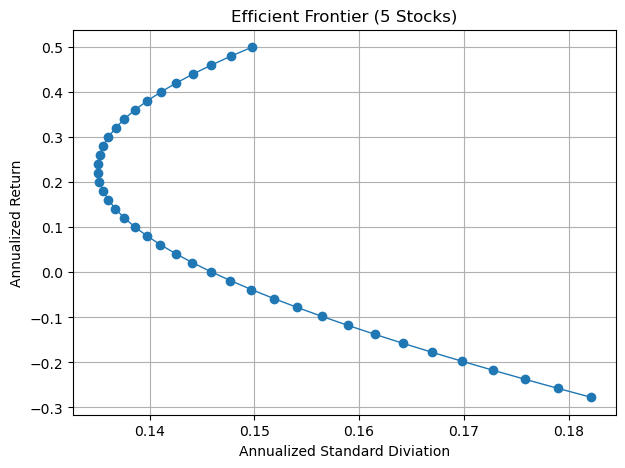

In [14]:
ret_min, ret_max = float(mu.min()), float(mu.max())
target_rets = np.linspace(ret_min, ret_max, 40)

long_only = True
frontier_stds = []
frontier_rets = []
frontier_w = []

for tr in target_rets:
    try:
        w = min_variance_for_target_return(mu, Sigma, tr, long_only=long_only)
        frontier_w.append(w)
        frontier_rets.append(portfolio_return(w, mu))
        frontier_stds.append(portfolio_std(w, Sigma))
    except RuntimeError:
        # 某些目标收益在 long-only 约束下不可达，跳过
        pass

plt.figure(figsize=(7, 5))
plt.plot(frontier_stds, frontier_rets, marker="o", linewidth=1)
plt.xlabel("Annualized Standard Diviation")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (5 Stocks)")
plt.grid(True)
plt.show()

## 对最终投资组合模型求解

In [15]:
# (a) 全局最小方差（GMV）
w_gmv = global_min_variance(mu, Sigma, long_only=long_only)

In [16]:
# (b) 最大夏普（给一个无风险利率 rf）
rf = 0.02
w_gms = max_sharpe(mu, Sigma, rf=rf, long_only=long_only)

## 用 Black-Litterman 模型进行后验均值和方差估计

### 参数设定

In [17]:
tickers = list(returns_df.columns)
n = len(tickers)
# tickers = ['600000.SH', '000001.SZ', '600519.SH', '000858.SZ', '601318.SH']

end_date = str(returns_df.index.max().date())
rf = 0.02

# 例：2 条观点
k = 2
P = np.zeros((k, n))
q = np.zeros(k)

# 观点1：600519.SH 相对 601318.SH 超额 5%
i_moutai = tickers.index("600519.SH")
i_pingan = tickers.index("601318.SH")
P[0, i_moutai] = 1.0
P[0, i_pingan] = -1.0
q[0] = 0.05

# 观点2：000001.SZ 年化收益 8%
i_vanke = tickers.index("000001.SZ")
P[1, i_vanke] = 1.0
q[1] = 0.08

# τ：先验不确定性（常用 0.025~0.1）
tau = 0.05  # 先验（π）不确定性缩放，越小表示更“坚信”均衡先验

# Ω：观点误差协方差（常用对角阵），越大表示观点越不确定
# 一个稳健默认：Ω = diag(P τΣ P^T)，表示观点方差与资产风险规模一致
Omega = np.diag(np.diag(P @ (tau * Sigma) @ P.T))

### 用公司市值计算w_mkt

In [18]:
def get_market_cap_weights(
    pro,
    tickers,
    end_date,
    lookback_days=20,    # 用近 N 个交易日市值均值更稳健（可调：1/5/20）
    cap_field="total_mv" # daily_basic 里：total_mv（总市值，单位通常为“万元”）
):
    """
    用 pro.daily_basic 拉每只股票的市值，并构造市值权重 w_mkt。
    
    实务上用期末附近 N 日平均市值，而不是单日，以降低偶然缺失/异常的影响。
    """
    end = _date_to_yyyymmdd(pd.to_datetime(end_date).strftime("%Y-%m-%d"))
    
    # 为了取到“期末附近最近的可用市值”，我们往前拉一段窗口（这里粗略拉 3*lookback_days 个日历日）
    start_dt = pd.to_datetime(end_date) - pd.Timedelta(days=3*lookback_days + 10)
    start = _date_to_yyyymmdd(start_dt.strftime("%Y-%m-%d"))

    caps = {}
    for code in tickers:
        df = pro.daily_basic(ts_code=code, start_date=start, end_date=end,
                             fields="ts_code,trade_date,total_mv")
        if df is None or df.empty:
            raise RuntimeError(f"{code}: daily_basic 返回空，无法取市值")
        df = df.sort_values("trade_date")  # trade_date: 'YYYYMMDD'
        # 取最后 lookback_days 行做均值（如果不足就用全部）
        mv = df[cap_field].astype(float).tail(lookback_days).mean()
        if not np.isfinite(mv) or mv <= 0:
            raise RuntimeError(f"{code}: 市值不可用/非正 ({mv})")
        caps[code] = mv

    cap_vec = np.array([caps[c] for c in tickers], dtype=float)
    w_mkt = cap_vec / cap_vec.sum()
    return w_mkt, pd.Series(caps).sort_values(ascending=False)

In [19]:
w_mkt, caps_series = get_market_cap_weights(
    pro=pro,
    tickers=tickers,
    end_date=end_date,
    lookback_days=20  # 可调：1/5/20
)

print("Market caps (avg over last N days, higher -> lower):")
display(caps_series.to_frame("total_mv_avg"))
print("\nMarket-cap weights w_mkt:")
display(pd.Series(w_mkt, index=tickers, name="w_mkt").sort_values(ascending=False).to_frame())

Market caps (avg over last N days, higher -> lower):


,total_mv_avg
600519.SH,1.936558e+08
601318.SH,7.633184e+07
000858.SZ,5.277919e+07
600000.SH,2.407612e+07
000001.SZ,2.024425e+07



Market-cap weights w_mkt:


,w_mkt
600519.SH,0.527547
601318.SH,0.207939
000858.SZ,0.143778
600000.SH,0.065587
000001.SZ,0.055148


### 从市场历史数据估计风险厌恶系数 $\delta$

In [20]:
def estimate_delta_from_market(mu, Sigma, w_mkt, rf=0.02):
    """
    hat(δ) = (E[R_m] - rf) / Var(R_m)
    其中 R_m 是“市场组合”的收益率（这里用 w_mkt 加权得到），mu/Sigma 是年化量。
    
    - δ 越大：越厌恶风险
    - δ 越小：越愿意冒险
    """
    mu_m = float(w_mkt @ mu)
    var_m = float(w_mkt @ Sigma @ w_mkt)
    if var_m <= 0:
        raise RuntimeError("Var(R_m) <= 0，无法估计 delta")
    delta = (mu_m - rf) / var_m
    return delta, mu_m, var_m

In [21]:
delta_hat, mu_m, var_m = estimate_delta_from_market(mu, Sigma, w_mkt, rf=rf)

### 得到市场隐含均衡超额收益 $\pi$

In [22]:
def implied_equilibrium_returns_pi(Sigma, w_mkt, delta):
    """
    hat(π) = hat(δ) Σ w_mkt
    
    - 在均值-方差效用最大化下：
        max_w  U(w) = w^T μ - (δ/2) w^T Σ w
        s.t.   1^T w = 1
    - 一阶条件（忽略约束细节，或在超额收益空间处理）给出：
        μ ≈ δ Σ w*   （w* 是最优权重）
    - 若假设“市场组合就是均衡下的最优组合”，即 w* = w_mkt，
      那么反推得到均衡下投资者“共同认可”的隐含收益：
        π = δ Σ w_mkt
    """
    return delta * (Sigma @ w_mkt)

In [23]:
pi_hat = implied_equilibrium_returns_pi(Sigma, w_mkt, delta_hat)

### Black-Litterman 后验：$\mu_{bl}$, $\Sigma_{bl}$

$$
\begin{align}
\ \hat{\mu}_{bl} =  [(\tau \Sigma)^{-1} + (P^T \Omega^{-1} P)]^{-1} [(\tau \Sigma)^{-1} \pi + (P^T \Omega^{-1} q) ] \\
\ \hat{\Sigma}_{bl} = \Sigma + [(\tau \Sigma)^{-1} + (P^T \Omega^{-1} P)]^{-1}
\end{align}
$$

In [24]:
def black_litterman_posterior(Sigma, pi, P, q, Omega, tau=0.05):
    tauSigma = tau * Sigma
    inv_tauSigma = np.linalg.inv(tauSigma)
    inv_Omega = np.linalg.inv(Omega)

    M = inv_tauSigma + P.T @ inv_Omega @ P
    M_inv = np.linalg.inv(M)

    mu_bl = M_inv @ (inv_tauSigma @ pi + P.T @ inv_Omega @ q)
    Sigma_bl = Sigma + M_inv
    return mu_bl, Sigma_bl

In [25]:
mu_hat_bl, Sigma_hat_bl = black_litterman_posterior(Sigma, pi_hat, P, q, Omega, tau=tau)

## 用 BL 后验进行资产配置

### 绘制有效前缘曲线

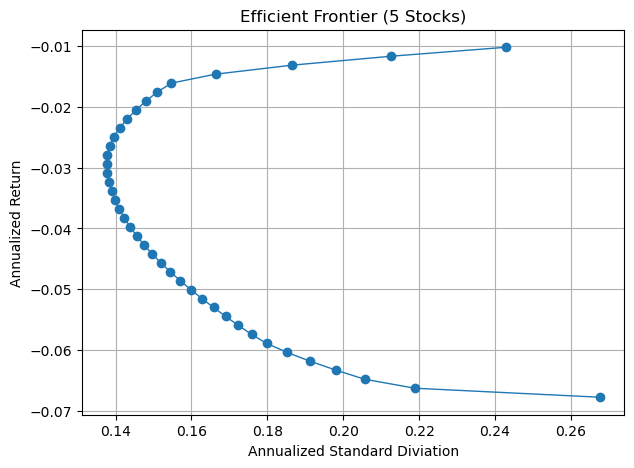

In [26]:
ret_min, ret_max = float(mu_hat_bl.min()), float(mu_hat_bl.max())
target_rets = np.linspace(ret_min, ret_max, 40)

long_only = True
frontier_stds = []
frontier_rets = []
frontier_w = []

for tr in target_rets:
    try:
        w = min_variance_for_target_return(mu_hat_bl, Sigma_hat_bl, tr, long_only=long_only)
        frontier_w.append(w)
        frontier_rets.append(portfolio_return(w, mu_hat_bl))
        frontier_stds.append(portfolio_std(w, Sigma_hat_bl))
    except RuntimeError:
        # 某些目标收益在 long-only 约束下不可达，跳过
        pass

plt.figure(figsize=(7, 5))
plt.plot(frontier_stds, frontier_rets, marker="o", linewidth=1)
plt.xlabel("Annualized Standard Diviation")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (5 Stocks)")
plt.grid(True)
plt.show()